<h1 style="text-align: center;"><b>Deep hedging</b></h1>
<h3 style="text-align: left;">Maksim Sosnin, Roland Grinis</h3>

# Theory

- A neural network (NN) is trained to hedge derivatives by trading the hedging instruments
- After training, the NN is used to calculate PV of the derivatives' portfolio and the optimal hedge at each time step
- Hedging instruments can be primary assets (e.g., equities) as well as secondary assets (e.g., liquid options)
- Market frictions are included (transaction costs, market impact, liquidity constraints, etc.)
- No dependence on the chosen market model
- No need to compute greeks
- NN's allow for very efficient numerical calculations of the optimal hedge
- Approximation of the optimal hedge computed by NN's is theoretically well-founded

Consider a discrete-time market with finite time horizon $T$ and trading dates
\begin{equation*}
    0 = t_0 < t_1 < ... < t_n = T.
\end{equation*}

Let $I_k \in \mathbb{R}^r$ be any new market information available at time $t_k$. Stochastic process 
$$I = (I_k)_{k=0,...,n}$$
generates filtration
$$\mathbb{F} = (\mathcal{F})_{k=0,...,n},$$
where $\mathcal{F}_k$ represents all information available up to $t_k$.

The market contains $d$ *hedging instruments* with mid-prices given by an $\mathbb{R}^d$-valued $\mathbb{F}$-adapted stochastic process
\begin{equation*}
    S = (S_k)_{k=0,...,n}, \quad S_k = (S_k^1, ..., S_k^d).
\end{equation*}

Our *portfolio of derivatives* (our liabilities) is an $\mathcal{F}_T$-measurable random variable $Z$.
At time $T$ the payment for portfolio of derivatives $Z$ is known.

To hedge a liability $Z$ at time $T$, we trade in $S$ using an $\mathbb{R}^d$-valued $\mathbb{F}$-adapted stochastic process (trading strategy)
\begin{equation*}
    \delta = (\delta_k)_{k=0,...,n-1}, \quad \delta_k = (\delta_k^1, ..., \delta_k^d),
\end{equation*}
where $\delta_k^i$ is our holdings of the $i$-th hedging instrument at time $t_k$.

For notational convenience, we define
\begin{equation*}
    \delta_{-1} = \delta_n := \mathbf{0}.
\end{equation*}

The wealth from trading a strategy $\delta$ is
\begin{equation*}
    (\delta \cdot S)_T := \sum_{k=0}^{n-1} \delta_k \cdot (S_{k+1} - S_k).
\end{equation*}

Trading activity causes *costs*: if we buy a position $\text{n} \in \mathbb{R}^d$ in $S$ at time $t_k$, this will incur cost $c_k(\mathrm{n}, S_k)$.

At time $T$ the total cost of trading a strategy $\delta$ is
\begin{equation*}
    C_T(\delta, S) := \sum_{k=0}^n c_k(\delta_k - \delta_{k-1}, S_k).
\end{equation*}

Thus, if we hedge a portfolio $Z$ by trading a strategy $\delta$ in $S$, our *final wealth at maturity* is
\begin{equation*}
    P(-Z, S, \delta) = -Z + (\delta \cdot S)_T - C_T(\delta, S).
\end{equation*}

A function $u : \mathbb{R} \to \mathbb{R}$ is called *utility function*, if it is
- non-decreasing,
- concave.

*Optimized certainty equivalent* of utility function $u$ for real-valued random variable $X$ is a function
\begin{equation*}
    \rho_u(X) := \inf_{w \in \mathbb{R}} \{ w - \mathbb{E}[u(X + w)] \}.
\end{equation*}

**Basically, we will use $\rho_u(X)$ as a loss function for neural network training.**

$\rho_u(X)$ is a *convex risk measure*, that is, satisfies the properties:
- non-increasing,
- convexity,
- cash equivalent: for $\eta \in \mathbb{R},\ \ \rho_u(X + \eta) = \rho_u(X) - \eta.$

*Optimal convex risk measure* is defined as the infimum
\begin{equation*}
    \pi_u(-Z) := \inf_\delta \rho_u(P(-Z, S, \delta)).
\end{equation*}

Finally, we can define a *utility indifference price* of portfolio $Z$ with respect to utility $u$:
\begin{equation*}
    p_u(Z) := \pi_u(-Z) - \pi_u(0).
\end{equation*}

Let $L \in \mathbb{N}$ be a number of layers.

Let $N_0, N_1, ..., N_L \in \mathbb{N}$ be numbers of neurons at each layer.

Let $W_l: \mathbb{R}^{N_{l-1}} \to \mathbb{R}^{N_l}$ be an affine function:
\begin{equation*}
    W_l(x) = A^l x + b^l, \quad A^l \in \mathbb{R}^{N_l \times N_{l-1}}, \quad b^l \in \mathbb{R}^{N_l}, \quad l = 0,...,L.
\end{equation*}

Let $\sigma: \mathbb{R} \to \mathbb{R}$ be activation function, applied element-wise.

A *feed-forward neural network* is a function $\mathrm{NN} : \mathbb{R}^{N_0} \to \mathbb{R}^{N_L}$:
\begin{equation*}
    \mathrm{NN} = W_L \circ \sigma \circ W_{L-1} \circ ... \circ \sigma \circ W_1.
\end{equation*}

In a feed-forward neural network $\mathrm{NN}$, the elements of all $A^l$ and $b^l$ are parameters.

In deep hedging approach, a hedging strategy is represented by a neural network:
\begin{equation*}
    \delta_{t_{i+1}} = \mathrm{NN}(I_{t_i}, \delta_{t_i}), \quad i = 0, ..., n. 
\end{equation*}

We train a neural network by optimizing a set of parameters $\theta$ of $\mathrm{NN}$ towards the infimal convex risk measure $\pi_u(-Z)$.
In other words, we use $\rho_u(X)$ as a loss function.

For training, we use Monte Carlo simulations of hedging instruments price paths. We can use modern optimization algorithms such as Adam.

After sufficient iterations, we can expect to obtain a close-to-optimal hedging strategy $\delta^*$. Strategy $\delta^*$ approximates the optimal convex risk measure:
\begin{equation*}
    \rho_u(P(-Z, S, \delta^*)) \simeq \pi_u(-Z),
\end{equation*}
and yields the approximate value of the utility indifference price $p_u(Z)$.

---

In [1]:
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import scipy
import torch
from torch.nn import Linear, ReLU
from tqdm.notebook import tqdm

from typing import Tuple, List, Optional
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt
import seaborn

from noa.docs.quant.pyquant.gbm import generate_gbm
from noa.docs.quant.pyquant.bsm import price_american_put_bs, find_early_exercise

torch.set_default_tensor_type(torch.FloatTensor)
np.random.seed(666777)
torch.manual_seed(666777)

seaborn.set_style('whitegrid')

In [2]:
import IPython
def _restart_kernel():
    IPython.Application.instance().kernel.do_shutdown(True)

# Introduction

Consider a portfolio of different derivatives with different strikes and maturities, with different underlying assets that have certain correlation structure and volatilities. Our goal is to hedge such portfolio in presence of transaction costs. We consider the Black-Scholes model and will use delta hedging as a benchmark. Then we will train a neural network to hedge the portfolio and compare PnL and costs distributions. We will show that deep hedging significantly outperforms delta hedging strategy by reducing losses from transaction costs.

We consider three underlyings:

In [3]:
# underlyings
N_UNDERS = 3

# correlation matrix
CORR = torch.tensor([[1.00,  0.30,  0.37],
                     [0.30,  1.00, -0.22],
                     [0.37, -0.22,  1.00]])

# volatilities
VOLATS = torch.tensor([0.25, 0.22, 0.23])

# initial values
S0 = torch.tensor([1.00, 0.70, 0.75])

and construct the portfolio of four derivatives:

|  Derivative   | # of underlying |
|:-------------:|:---------------:|
| American Put  |        1        |
| European Call |        1        |
| European Put  |        2        |
| European Call |        3        |

In [4]:
# derivatives
N_DERIVS = 4
STRIKES =    torch.tensor([0.99,   1.05,    0.65,   0.75])
MATURITIES = torch.tensor([90/250, 70/250,  50/250, 50/250])

For simplicity, we set risk-free rate to zero.

In [5]:
RATE = torch.tensor([0.])

In [6]:
COST = 0.01       # Transaction cost
N_PATHS = 10_000  # Number of simulated underlying paths for one batch
N_BATCHES = 9     # Number of batches for validation

## Simulation of correlated GBM underlyings

In [7]:
COV = torch.diag(VOLATS) @ CORR @ torch.diag(VOLATS)
cov_eigvals = torch.linalg.eigvals(COV)

print('Covariance matrix:', COV, sep='\n')
print('\nPositive definite:',
      torch.all(torch.isreal(cov_eigvals)) and torch.all(torch.real(cov_eigvals) > 0).item())

Covariance matrix:
tensor([[ 0.0625,  0.0165,  0.0213],
        [ 0.0165,  0.0484, -0.0111],
        [ 0.0213, -0.0111,  0.0529]])

Positive definite: True


In [8]:
paths_example = generate_gbm(n_paths=100, n_steps=90, dt=1/250,
                             S0=S0, sigma=COV, drift=RATE)

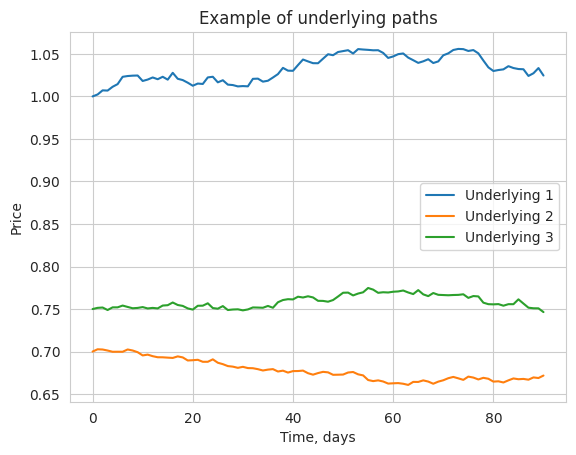

In [9]:
path_idx = 0
for i in range(len(paths_example)):
    plt.plot(paths_example[i, path_idx], label=f'Underlying {i + 1}')
plt.legend()
plt.title('Example of underlying paths')
plt.xlabel('Time, days')
plt.ylabel('Price')
plt.show()

# Portfolio and hedging model representation

In [10]:
NORMAL_DISTR = torch.distributions.Normal(0, 1)

def bs_euro_call_delta(S, t, strike, maturity, sigma, rate):
    """Calculates Delta greek of European call option under the Black-Scholes model.

    Args:
        S: Price of the underlying.
        strike: Strike of the option.
        maturity: Maturity of the option.
        t: Time value.
        sigma: Volatility parameter of Black-Scholes model.
        rate: Risk-free rate.

    Returns:
        Delta of European call option.
    """
    tau = maturity - t
    d1 = (torch.log(S / strike) + (rate + 0.5 * sigma ** 2) * tau) / (sigma * torch.sqrt(tau))
    return NORMAL_DISTR.cdf(d1)


def bs_euro_put_delta(S, t, strike, maturity, sigma, rate):
    tau = maturity - t
    d1 = (torch.log(S / strike) + (rate + 0.5 * sigma ** 2) * tau) / (sigma * torch.sqrt(tau))
    return -NORMAL_DISTR.cdf(-d1)


def get_delta(V: np.ndarray, dS: float):
    """Calculates delta greek of the derivative by numerical differentiation.
    Args:
        V:
            Values of the derivative on the (S, t) grid. The grid must
            have uniform spacing in S. Shape: (npoints_S, npoints_t).
        dS:
            Step size in variable S on the grid.
    Returns:
        Delta of the derivative on the (S, t) grid. Shape: (npoints_S, npoints_t).
    """
    delta = np.empty_like(V)
    delta[0] = -1.5*V[0]  + 2*V[1]  - 0.5*V[2]
    delta[-1] = 0.5*V[-3] - 2*V[-2] + 1.5*V[-1]
    for i in range(1, V.shape[0] - 1):
        delta[i] = -0.5*V[i-1] + 0.5*V[i+1]
    delta /= dS
    return delta


def call_payoff(S, strike):
    return torch.maximum(S - strike, torch.zeros_like(S))


def put_payoff(S, strike):
    return torch.maximum(strike - S, torch.zeros_like(S))

In [11]:
class Portfolio:
    """Represents the portfolio of derivatives.

        Args:
            n_paths:
                Number of underlying paths to simulate.
            dt:
                Time step for paths simulation.
            compute_amer_delta:
                Whether to compute delta of the American option. Not doing so will avoid If `False`,
                `self.get_delta()` will raise `RuntimeError`.
    """
    def __init__(self, n_paths: int, dt: float, compute_amer_delta: bool = True):
        self.n_paths = n_paths
        self.dt = dt
        self.compute_amer_delta = compute_amer_delta

        self.n_unders = N_UNDERS
        self.n_derivs = N_DERIVS
        self.rate = RATE               # Shape: (1, )
        self.corr = CORR               # Shape: (N_UNDERS, N_UNDERS)
        self.volats = VOLATS           # Shape: (N_UNDERS, )
        self.S0 = S0                   # Shape: (N_UNDERS, )
        self.strikes = STRIKES         # Shape: (N_DERIVS, )
        self.maturities = MATURITIES   # Shape: (N_DERIVS, )

        # Number of *time steps* (not time points) until the expiration of
        # the derivative with the largest maturity.
        # Equivalently, the number of time points without counting initial
        # moment of time (t = 0).
        self.n_steps = round(torch.max(self.maturities).item() / self.dt)
        self.t_arr = self.dt * torch.arange(0, self.n_steps + 1, 1)
        self.expiry_indexes = torch.argmin(
            torch.abs(self.maturities.unsqueeze(dim=1) - self.t_arr),
            dim=1
        )

        # Shape: (N_UNDERS, N_UNDERS)
        self.cov = torch.diag(self.volats) @ self.corr @ torch.diag(self.volats)
        # Shape: (N_UNDERS, N_PATHS, N_STEPS + 1)
        self.paths = None
        self.simulate()

        AMER_S_MIN = self.S0[0].item() * 0.05
        AMER_S_MAX = self.S0[0].item() * 3
        AMER_NPOINTS_S = 4000
        AMER_NPOINTS_T = 1000
        AMER_NPOINTS_S_UNIFORM = 50000

        amer_price, amer_S, amer_t = price_american_put_bs(
            self.strikes[0].item(),
            self.maturities[0].item(),
            self.rate.item(),
            self.volats[0].item(),
            AMER_S_MIN,
            AMER_S_MAX,
            AMER_NPOINTS_S,
            AMER_NPOINTS_T
        )
        _, amer_stop_S = find_early_exercise(
            amer_price, amer_S, amer_t, self.strikes[0].item(), 1e-5)
        self.amer_stop_S = torch.Tensor(
            scipy.interpolate.interp1d(amer_t, amer_stop_S, kind='linear')(self.t_arr))
        self.amer_early_payoff = put_payoff(self.amer_stop_S, self.strikes[0])

        if not self.compute_amer_delta:
            self.amer_delta = None
        else:
            # Use interpolation to compute the values of American put on a grid
            # which is uniform in variable S
            amer_S_uniform, amer_S_unif_step = np.linspace(
                amer_S.min(), amer_S.max(), AMER_NPOINTS_S_UNIFORM, retstep=True)
            amer_price_uniform = scipy.interpolate.interpn(
                (amer_S, amer_t),
                amer_price,
                tuple(np.meshgrid(amer_S_uniform, amer_t, indexing='ij')),
                method='linear'
            )
            amer_delta_vals = get_delta(amer_price_uniform, amer_S_unif_step)
            self.amer_delta = scipy.interpolate.RegularGridInterpolator(
                points=(amer_S_uniform, amer_t),
                values=amer_delta_vals,
                method='linear'
            )

    def simulate(self):
        """Generates the paths of underlyings of the portfolio.
        self.paths have the shape (self.n_unders, self.n_paths, self.n_steps + 1)
        """
        self.paths = generate_gbm(self.n_paths, self.n_steps,
                                  self.dt, self.S0, self.cov, self.rate)

    def get_delta(self) -> torch.Tensor:
        """Calculates delta of the portfilio w.r.t. each underlying at each moment of time.
        At the expiry of the derivative the delta is considered zero.
        Returns:
            Delta of the portfolio at each moment of time. Shape: same as `self.paths`.
        """
        if not self.compute_amer_delta:
            raise RuntimeError('Delta of American option is not computed.')

        delta = torch.zeros_like(self.paths)
        amer_exercised = torch.zeros(self.n_paths, dtype=torch.bool)
        for j in range(0, self.n_steps):
            # 1. American Put
            amer_delta_j = self.amer_delta(
                torch.vstack(
                    (self.paths[0, :, j], torch.full((self.n_paths, ), self.t_arr[j]))
                ).T.numpy()
            )
            # no longer hedge American Put if underlying crossed the early-exercise curve
            amer_exercised += torch.le(self.paths[0, :, j], self.amer_stop_S[j])
            delta[0, :, j] += torch.where(amer_exercised, 0, torch.from_numpy(amer_delta_j))
            # 2. European Call
            if self.t_arr[j] < self.maturities[1]:
                delta[0, :, j] += bs_euro_call_delta(
                    self.paths[0, :, j], self.t_arr[j], self.strikes[1],
                    self.maturities[1], self.volats[0], self.rate)
            # 3. European Put
            if self.t_arr[j] < self.maturities[2]:
                delta[1, :, j] += bs_euro_put_delta(
                    self.paths[1, :, j], self.t_arr[j], self.strikes[2],
                    self.maturities[2], self.volats[1], self.rate)
            # 4. European Call
            if self.t_arr[j] < self.maturities[3]:
                delta[2, :, j] += bs_euro_call_delta(
                    self.paths[2, :, j], self.t_arr[j], self.strikes[3],
                    self.maturities[3], self.volats[2], self.rate)
        return delta

    def get_log_moneyness(self, time_idx: int):
        """Calculates log-moneyness of each derivative in portfolio.

        Log-moneyness is ln(S/K), where S is the price of the underlying,
        and K is the strike of the derivative.

        Args:
            time_idx: An index of time point. Must be less than `self.n_steps + 1`.
        Returns:
            Log-moneyness of each derivative.
            Shape: (self.n_paths, self.n_derivs)
        """
        log_mon = torch.empty(self.n_paths, self.n_derivs)
        log_mon[:, 0] = torch.log(self.paths[0, :, time_idx] / self.strikes[0])
        log_mon[:, 1] = torch.log(self.paths[0, :, time_idx] / self.strikes[1])
        log_mon[:, 2] = torch.log(self.paths[1, :, time_idx] / self.strikes[2])
        log_mon[:, 3] = torch.log(self.paths[2, :, time_idx] / self.strikes[3])
        return log_mon

    def get_time_expiry(self, time_idx: int):
        """Calculates time left until expiration of each derivative in portfolio.
        Args:
            time_idx: An index of time point. Must be less than (self.n_steps + 1).
        Returns:
            Time left until expiration of each derivative.
            Shape: (self.n_derivs, ).
        """
        return self.maturities - self.t_arr[time_idx]

    def get_payoff(self) -> torch.Tensor:
        """Calcaultes payoff of the portfolio.
        Returns:
            Payoff of the portfolio for each simulated path of underlyings.
            Shape: (self.n_paths,).
        """
        payoff = torch.zeros(self.n_paths)

        # 1. American Put
        early_hits = torch.argmax(
            torch.le(
                self.paths[0, :, :self.expiry_indexes[0]+1],
                self.amer_stop_S
            ).to(torch.uint8),
            dim=1
        )
        amer_payoff = torch.where(
            early_hits > 0,
            torch.take(self.amer_early_payoff, early_hits),
            0)
        payoff += amer_payoff

        # 2. European Call
        payoff += call_payoff(self.paths[0, :, self.expiry_indexes[1]], self.strikes[1])

        # 3. European Put
        payoff += put_payoff(self.paths[1, :, self.expiry_indexes[2]], self.strikes[2])

        # 4. European Call
        payoff += call_payoff(self.paths[2, :, self.expiry_indexes[3]], self.strikes[3])

        return payoff

In [12]:
class BaseHedger(ABC):
    """Base class for hedging model.
    Attributes:
        portfolio:
            Portfolio to hedge.
        under_indexes:
            A list of indexes of underlyings to use for hedging. Indexes must
            be unique integers in range [0, self.portfolio.n_unders-1].
            If `None`, all underlyings are used.
        device:
            Torch device to work on.
    """

    def __init__(
            self,
            portfolio: Portfolio,
            under_indexes: Optional[List] = None,
            device='cpu'
    ):
        self.portfolio = portfolio
        self.device = device

        if under_indexes is not None:
            if len(set(under_indexes)) != len(under_indexes):
                raise ValueError('`under_indexes` must contain unique integers')
            if min(under_indexes) < 0 or max(under_indexes) > self.portfolio.n_unders - 1:
                raise ValueError('`under_indexes` must contain integers in range [1, self.portfolio.n_unders]')
            self.under_indexes = under_indexes
        else:
            self.under_indexes = list(range(0, self.portfolio.n_unders))

    @abstractmethod
    def get_hedge(
            self,
            time_idx: int,
            prev_hedge: Optional[torch.Tensor],
    ) -> torch.Tensor:
        """Calculates the hedge amount for the portfolio at given time.
        Args:
            time_idx:
                An index of time point. Must be less than `self.portfolio.n_steps + 1`.
            prev_hedge:
                Hedge amount at previous moment of time.
        Returns:
            A tensor with hedge amount in all or some of the underlyings
            of the portfolio for each path.
            Shape: (N, len(under_indexes)), where N is the number of paths.
        """
        pass

    def compute_pnl(self, cost: float) -> Tuple[torch.Tensor, torch.Tensor]:
        """Computes PnL and costs distribution after hedging a portfolio.

        Args:
            cost: Transaction cost.
        Returns:
            1) PnL. Shape: (self.portfolio.n_paths, ).
            2) Costs. Shape: (self.portfolio.n_paths, ).
        """
        pnl = torch.zeros(self.portfolio.n_paths).to(self.device)
        costs = torch.zeros(self.portfolio.n_paths).to(self.device)
        prev_hedge = torch.zeros(len(self.under_indexes), self.portfolio.n_paths).to(self.device)

        for j in range(0, self.portfolio.n_steps + 1):
            if j != 0:
                pnl += torch.sum(
                    prev_hedge * (self.portfolio.paths[self.under_indexes, :, j] -
                                  self.portfolio.paths[self.under_indexes, :, j-1]).to(self.device),
                    dim=0
                )

            hedge = self.get_hedge(
                time_idx=j, prev_hedge=torch.swapaxes(prev_hedge, 0, 1))

            current_cost = torch.sum(cost * torch.abs(hedge - prev_hedge), dim=0)
            costs -= current_cost
            pnl -= current_cost
            prev_hedge = hedge
        pnl -= self.portfolio.get_payoff().to(self.device)
        return pnl, costs

    def compute_pnl_nbatches(self, cost, n_batches):
        pnl = torch.empty(0)
        costs = torch.empty(0)
        for _ in tqdm(range(n_batches)):
            self.portfolio.simulate()
            pnl_batch, costs_batch = self.compute_pnl(cost)
            pnl = torch.cat((pnl, pnl_batch.to('cpu')))
            costs = torch.cat((costs, costs_batch.to('cpu')))
        return pnl, costs

In [13]:
def plot_pnl_costs(pnl, costs, n_bins=110):
    plt.hist(pnl, density=True, bins=n_bins)
    plt.title('PnL distribution')
    plt.xlabel('PnL')
    plt.ylabel('Density')
    plt.show()

    plt.hist(costs, density=True, bins=n_bins)
    plt.title('Costs distribution')
    plt.xlabel('Cost')
    plt.ylabel('Density')
    plt.show()

# 1. Benchmark: Black-Scholes delta hedging

In [14]:
class BSDeltaHedger(BaseHedger):
    def __init__(self, portfolio: Portfolio):
        super().__init__(portfolio)
        self.portf_delta = self.portfolio.get_delta()

    def get_hedge(self, time_idx: int, prev_hedge: Optional[torch.Tensor] = None) -> torch.Tensor:
        return self.portf_delta[..., time_idx]

    def compute_pnl_nbatches(self, cost, n_batches):
        pnl = torch.empty(0)
        costs = torch.empty(0)
        for _ in tqdm(range(n_batches)):
            self.portfolio.simulate()
            self.portf_delta = self.portfolio.get_delta()
            pnl_batch, costs_batch = self.compute_pnl(cost)
            pnl = torch.cat((pnl, pnl_batch.to('cpu')))
            costs = torch.cat((costs, costs_batch.to('cpu')))
        return pnl, costs

In [ ]:
portfolio_delta = Portfolio(n_paths=N_PATHS, dt=1/250)

In [16]:
bs_delta_hedger = BSDeltaHedger(portfolio_delta)

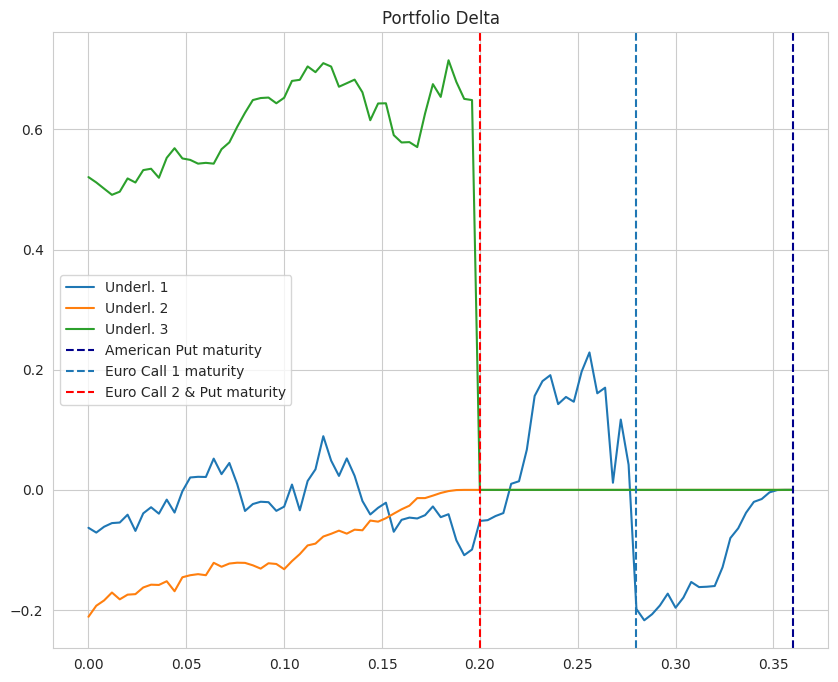

In [17]:
path_idx = 5
plt.figure(figsize=(10, 8))
for i in range(portfolio_delta.n_unders):
    plt.plot(portfolio_delta.t_arr,
             bs_delta_hedger.portf_delta[i, path_idx, :],
             label=f'Underl. {i+1}')
plt.title('Portfolio Delta')
plt.axvline(MATURITIES[0], ls='--', c='darkblue', label='American Put maturity')
plt.axvline(MATURITIES[1], ls='--', label='Euro Call 1 maturity')
plt.axvline(MATURITIES[2], ls='--', c='red', label='Euro Call 2 & Put maturity')
plt.legend()
plt.show()

In [18]:
pnl_deltahedge, costs_deltahedge = \
    bs_delta_hedger.compute_pnl_nbatches(COST, N_BATCHES)

  0%|          | 0/9 [00:00<?, ?it/s]

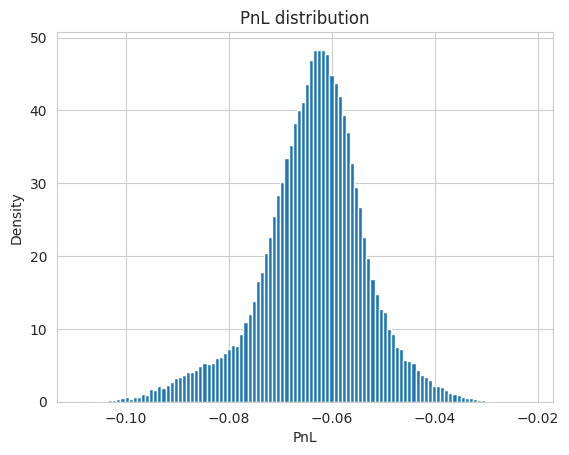

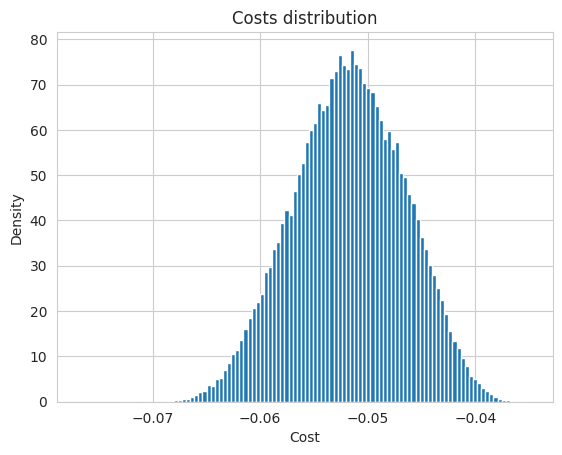

In [19]:
plot_pnl_costs(pnl_deltahedge, costs_deltahedge)

# 2. Deep hedging with all underlyings

In [11]:
class BaseLoss(torch.nn.Module, ABC):
    """Base class for hedging criteria."""

    @abstractmethod
    def forward(self, pnl: torch.Tensor) -> torch.Tensor:
        """Returns the loss of the PnL distribution.
        Args:
            pnl: The PnL distribution. Shape: (N, ).
        Returns:
            Loss. Shape: (1, ).
        """
        pass


class EntropicLoss(BaseLoss):
    def __init__(self, risk_aversion):
        super().__init__()
        self.a = risk_aversion

    def forward(self, pnl: torch.Tensor) -> torch.Tensor:
        return -torch.mean(-torch.exp(-self.a * pnl))


class EntropicRiskMeasure(BaseLoss):
    def __init__(self, risk_aversion):
        super().__init__()
        self.a = risk_aversion

    def forward(self, pnl: torch.Tensor) -> torch.Tensor:
        return (1/self.a) * torch.log(-torch.mean(-torch.exp(-self.a * pnl)))


class ExpectedShortfall(BaseLoss):
    def __init__(self, quantile):
        super().__init__()
        self.q = quantile

    def forward(self, pnl: torch.Tensor) -> torch.Tensor:
        return -pnl.topk(math.ceil(self.q * pnl.numel()), largest=False).values.mean()

In [12]:
class MultiLayerPerceptron(torch.nn.ModuleList):
    def __init__(self, in_features, out_features, n_layers=4, n_units=32):
        super().__init__()
        for n in range(n_layers):
            i = in_features if n == 0 else n_units
            self.append(Linear(i, n_units))
            self.append(ReLU())
        self.append(Linear(n_units, out_features))

    def forward(self, x):
        for layer in self:
            x = layer(x)
        return x

In [13]:
class DeepHedger(BaseHedger):
    def __init__(
            self,
            portfolio: Portfolio,
            under_indexes: Optional[List] = None,
            device='cpu'
    ):
        super().__init__(portfolio, under_indexes, device)
        self.mlp = MultiLayerPerceptron(
            in_features=portfolio.n_derivs * 2 + len(self.under_indexes),
            out_features=len(self.under_indexes)
        ).to(self.device)

    def get_hedge(
            self,
            time_idx: int,
            prev_hedge: torch.Tensor
    ) -> torch.Tensor:
        if prev_hedge is None:
            raise ValueError('`DeepHedger` cannot calculate the hedge without'
                             'knowing the previous hedge')
        log_mon = self.portfolio.get_log_moneyness(time_idx).to(self.device)
        time_expiry = self.portfolio.get_time_expiry(time_idx).to(self.device)
        input_data = torch.hstack((
            log_mon,
            time_expiry.repeat(self.portfolio.n_paths, 1),
            prev_hedge
        ))
        hedge = self.mlp(input_data)
        return torch.swapaxes(hedge, 0, 1)

    def parameters(self):
        return self.mlp.parameters()

    def fit(
            self,
            optimizer: torch.optim.Optimizer,
            n_epochs: int,
            cost: float,
            loss_module: BaseLoss
    ) -> List[float]:
        loss_history = []
        self.mlp.train()
        for _ in tqdm(range(n_epochs)):
            self.portfolio.simulate()
            optimizer.zero_grad()
            pnl, _ = self.compute_pnl(cost)
            loss = loss_module(pnl)
            loss.backward()
            optimizer.step()
            loss_history.append(loss.item())
        self.mlp.eval()
        return loss_history

In [14]:
def plot_loss_history(loss_history: list, title: str, loss_name: str):
    plt.plot(list(range(1, len(loss_history) + 1)), loss_history)
    plt.title(title)
    plt.ylabel(loss_name)
    plt.xlabel('Epoch')
    plt.show()

In [15]:
TRAIN_COST = 0.001
N_EPOCHS = 230

In [ ]:
portfolio_deep = Portfolio(n_paths=N_PATHS, dt=1/250, compute_amer_delta=False)
deep_hedger = DeepHedger(portfolio_deep, under_indexes=None, device='cuda')
optimizer = torch.optim.Adam(deep_hedger.parameters())
loss_history = deep_hedger.fit(optimizer, n_epochs=N_EPOCHS, cost=TRAIN_COST,
                               loss_module=ExpectedShortfall(0.2))

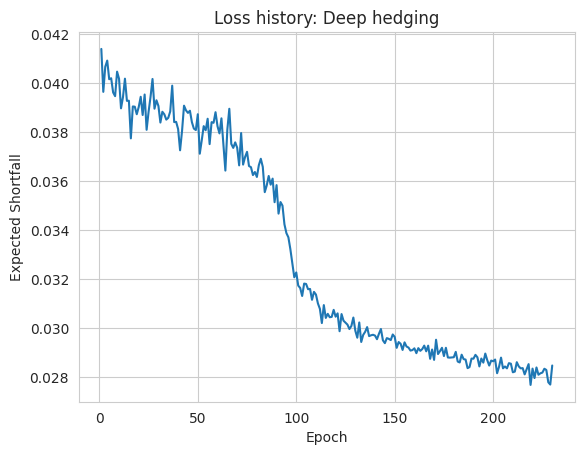

In [17]:
plot_loss_history(loss_history, title='Loss history: Deep hedging',
                  loss_name='Expected Shortfall')

In [ ]:
pnl_deephedge, costs_deephedge = \
    deep_hedger.compute_pnl_nbatches(COST, N_BATCHES)

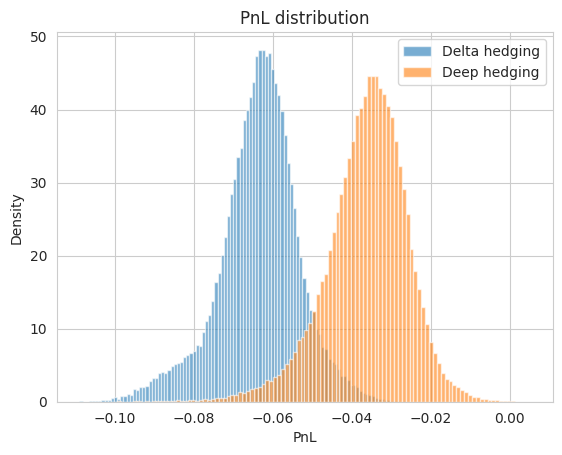

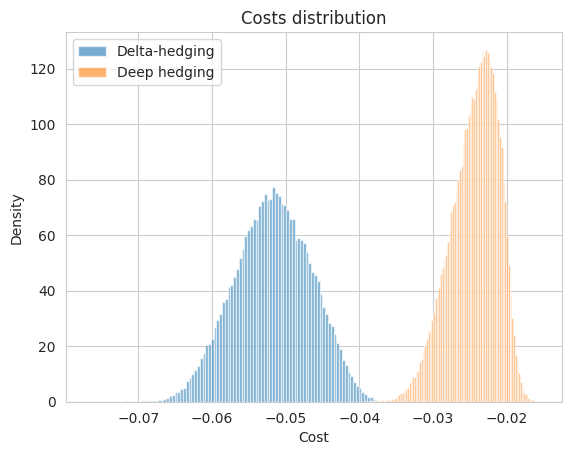

In [20]:
N_BINS = 110
ALPHA = 0.6

plt.hist(pnl_deltahedge, density=True, bins=N_BINS, label='Delta hedging', alpha=ALPHA)
plt.hist(pnl_deephedge.detach(), density=True, bins=N_BINS, label='Deep hedging', alpha=ALPHA)
plt.title('PnL distribution')
plt.xlabel('PnL')
plt.ylabel('Density')
plt.legend()
plt.show()

plt.hist(costs_deltahedge, density=True, bins=N_BINS, label='Delta-hedging', alpha=ALPHA)
plt.hist(costs_deephedge.detach(), density=True, bins=N_BINS, label='Deep hedging', alpha=ALPHA)
plt.title('Costs distribution')
plt.xlabel('Cost')
plt.ylabel('Density')
plt.legend()
plt.show()

We can see that with deep hedging transaction costs for hedging a portfolio are greatly reduced.

# 3. Deep hedging using only one underlying

We can train neural network to hedge the whole portfolio without using all underlyings, which can reduce the costs even more.

Here we consider using only underlying #1.

In [ ]:
portfolio_partial = Portfolio(n_paths=N_PATHS, dt=1/250, compute_amer_delta=False)
deep_hedger_partial = DeepHedger(portfolio_partial, under_indexes=[0], device='cuda')

optimizer = torch.optim.Adam(deep_hedger_partial.parameters())
loss_history = deep_hedger_partial.fit(
    optimizer,
    n_epochs=N_EPOCHS,
    cost=TRAIN_COST,
    loss_module=ExpectedShortfall(0.2)
)

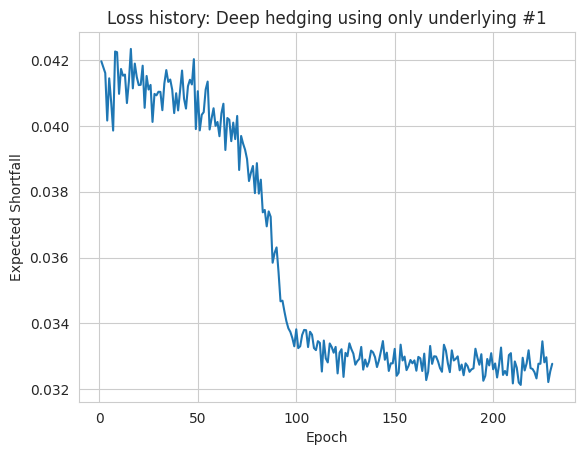

In [22]:
plot_loss_history(loss_history, title='Loss history: Deep hedging using only underlying #1',
                  loss_name='Expected Shortfall')

In [ ]:
pnl_deep_partial, costs_deep_partial = \
    deep_hedger_partial.compute_pnl_nbatches(COST, N_BATCHES)

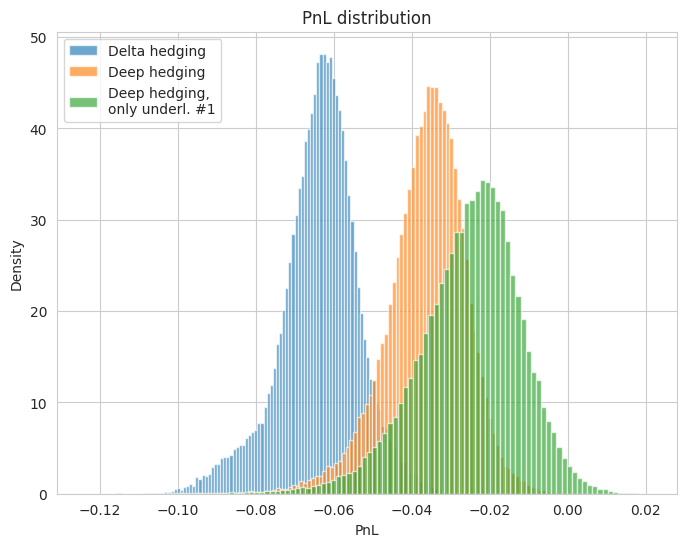

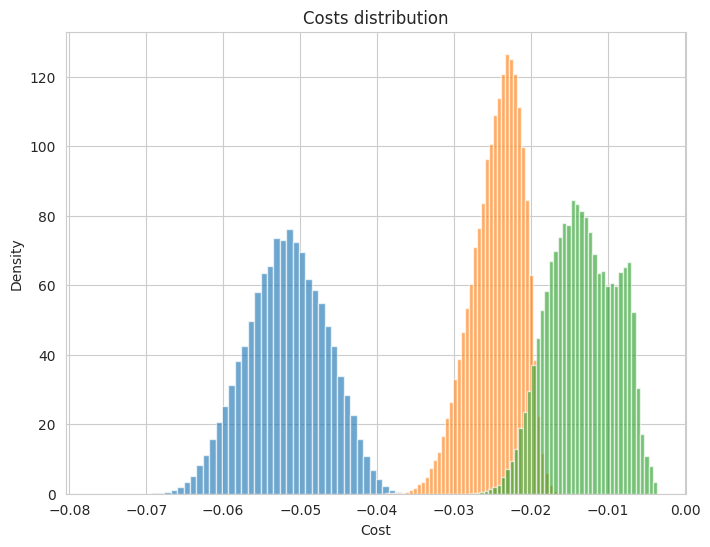

In [39]:
ALPHA = 0.65

plt.figure(figsize=(8, 6))
plt.hist(pnl_deltahedge, density=True, bins=110, label='Delta hedging', alpha=ALPHA)
plt.hist(pnl_deephedge.detach(), density=True, bins=110, label='Deep hedging', alpha=ALPHA)
plt.hist(pnl_deep_partial.detach(), density=True, bins=110, alpha=ALPHA,
         label='Deep hedging,\nonly underl. #1')
plt.title('PnL distribution')
plt.xlabel('PnL')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(costs_deltahedge, density=True, bins=50, label='Delta hedging', alpha=ALPHA)
plt.hist(costs_deephedge.detach(), density=True, bins=50, label='Deep hedging', alpha=ALPHA)
plt.hist(costs_deep_partial.detach(), density=True, bins=50, alpha=ALPHA,
         label='Deep hedging,\nonly underl. #1')
plt.title('Costs distribution')
plt.xlabel('Cost')
plt.ylabel('Density')
plt.show()

# References

- [Buehler2019] Buehler, Hans, et al. "Deep hedging." Quantitative Finance 19.8 (2019): 1271-1291.